# Document Classification

We are team 13: the aim of our project was to train a classifier on Shakespere and Reuters News documents in order to classify text into either of the two classes.

### Module imports

In [1]:
from concurrent import futures
import nltk
from nltk.corpus import reuters, stopwords
from scipy import sparse
import string
from collections import defaultdict, Counter
import numpy as np
import os
import sys
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import word_tokenize
import sklearn
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.util import ngrams
import re
NUM_THREADS = 24

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

nltk.download('reuters')
nltk.download('stopwords')
nltk.download('punkt')

reuters_freqThreshold = 5000
shakespeare_freqThreshold = 5000

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\monish\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monish\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Preprocessing

## Reuters Data Scrubbing

In [2]:
print(len(reuters.fileids()))
punctuation = string.punctuation.replace("'", "")
stopset = set(stopwords.words("english"))

def thread_task(rawWords):
    freqMap = defaultdict(int)
    #convert to lowercase
    lower = [word.lower() for word in rawWords]
    
    #remove punctuation from tokens
    punc_filter = str.maketrans('', '', punctuation)
    stripped = [word.translate(punc_filter) for word in lower]
    
    #remove remaining alphanumerics
    words = [word for word in stripped if word.isalpha()]
    
    #filter out basic stopwords
    cleaned_word_bank = [word for word in words if word not in stopset]
    
    for word in cleaned_word_bank:
        freqMap[word] += 1
    return freqMap

def thread_exec(WORDS):
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
        results = list(ex.map(thread_task, WORDS))
    return results


10788


In [3]:
freqMap = defaultdict(int)
REUTERS_WORDS = [[str(word) for word in reuters.words(file)] for file in reuters.fileids()][0:10000]
t = thread_exec(REUTERS_WORDS)
for ifreqMap in t:
    for k in ifreqMap.keys():    
        freqMap[k] += ifreqMap[k]    
        
freqTuples = list(freqMap.items())
sorted_freq = freqTuples.sort(key= lambda x: x[1], reverse=True)
topTuples_r = freqTuples[:reuters_freqThreshold]
filtered_vocab = [tup[0] for tup in topTuples_r]
reuters_vocab_np = np.asarray(filtered_vocab, dtype='str')
print(reuters_vocab_np.shape)

(1,)


## Shakespeare Data Scrubbing

In [4]:
folder = './Shake_works'
sub = "[^a-zA-Z' ]+"
all_files = [file for t,y, file in os.walk(folder)][0]
stopset = set(stopwords.words("english"))

def thread_task(rawWords):
    freqMap = defaultdict(int)
    words = [re.sub(sub, '', word) for word in rawWords]
    lower = [word.lower() for word in words]
    words = [word for word in lower if word.isalpha()]
    cleaned_word_bank = [word for word in words if word not in stopset]    
    
    for word in cleaned_word_bank:
        freqMap[word] += 1
    return freqMap

def thread_exec(WORDS):
    with futures.ThreadPoolExecutor(max_workers=NUM_THREADS) as ex:
        results = list(ex.map(thread_task, WORDS))
    return results
    

In [5]:
freqMap = defaultdict(int)
SHAKESPEARE_WORDS = [[str(word) for word in open(folder+'/'+file).read().split()] for file in all_files]
t = thread_exec(SHAKESPEARE_WORDS)
for ifreqMap in t:
    for k in ifreqMap.keys():    
        freqMap[k] += ifreqMap[k]   
        
freqTuples = list(freqMap.items())
sorted_freq = freqTuples.sort(key= lambda x: x[1], reverse=True)
topTuples_s = freqTuples[:shakespeare_freqThreshold]
filtered_vocab = [tup[0] for tup in topTuples_s]
shakespeare_vocab_np = np.asarray(filtered_vocab, dtype='str')
print(shakespeare_vocab_np.shape)

(100,)


## (optional) output top words/frequencies to a file

In [6]:
reuters_freq_file = open("reuters_frequencies.txt", "w+")
shakes_freq_file = open("shakes_frequencies.txt", "w+")

for tup in topTuples_r:
    reuters_freq_file.write(f"{tup[0]}, {tup[1]}")
for tup in topTuples_s:
    shakes_freq_file.write(f"{tup[0]}, {tup[1]}")
    
reuters_freq_file.close()
shakes_freq_file.close()

## Create one hot encoded tensor mapping documents to vocabulary

In [7]:
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

vocab = reuters_vocab_np
tmp = list()
for word in shakespeare_vocab_np:
    if(word not in vocab):
        tmp.append(word)
vocab = np.append(vocab, tmp)
print(vocab.shape)


shakespeare_data = []
i=0
punc_filter = str.maketrans('', '', punctuation)
progress = IntProgress(min=0, max=len(SHAKESPEARE_WORDS))
label = HTML()
box = VBox(children=[label, progress])
display(box)
for doc in SHAKESPEARE_WORDS:
    shakespeare_data.append(np.zeros(vocab.shape))
    #print(doc)
    for word in doc:
        word = re.sub(sub,'',word).lower()
        shakespeare_data[i][vocab==word] = 1.0
    i+=1
    progress.value += 1
    label.value = u'{name}: {index} / {size}'.format(
                        name="Docs",
                        index=i,
                        size=len(SHAKESPEARE_WORDS)
                    )
shakespeare_data = np.array(shakespeare_data)   


reuters_data = []
i=0
punc_filter = str.maketrans('', '', punctuation)
progress = IntProgress(min=0, max=len(REUTERS_WORDS))
label = HTML()
box = VBox(children=[label, progress])
display(box)
for doc in REUTERS_WORDS:
    reuters_data.append(np.zeros(vocab.shape))
    for word in doc:
        word = word.lower()
        word = word.translate(punc_filter)
        reuters_data[i][vocab==word] = 1.0
    i+=1   
    progress.value += 1
    label.value = u'{name}: {index} / {size}'.format(
                        name="Docs",
                        index=i,
                        size=len(REUTERS_WORDS)
                    )
reuters_data = np.array(reuters_data)


(101,)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

### Make our feature vector X and class vector Y

X is a matrix where a column represents a word, and a row represents a document in our feature space of documents, where a 1 meants word containment in the document, and 0 means absence of the word

In [8]:
X = shakespeare_data
y = np.zeros(X.shape[0])

X = np.concatenate((X, reuters_data), axis=0)
y = np.concatenate((y, np.ones(reuters_data.shape[0])), axis=0)

vocab = np.array(vocab, dtype=np.str)

print(X.shape)
print(y.shape)
print(vocab.shape)

X.dump('X')
y.dump('y')
vocab.dump('vocab')

(10042, 101)
(10042,)
(101,)


# Train Models

In [9]:
X = np.load('X')
y = np.load('y')
vocab = np.load('vocab')
models = [(BernoulliNB(), "Bernoulli Naive Bayes"), 
          (GaussianNB(), "Gaussian Naive Bayes"),
          (LogisticRegression(), "Logistic Regression"),
          (KNeighborsClassifier(n_neighbors=5), "K Nearest Neighbours"),
          (svm.SVC(), "Support Vector Machine")]

### Define utility functions

In [10]:
#prints the misclassification rate
#precision error = 1 guessed as a 0 erros
#recall = 0 guessed as 1 errors
def difference(l1,l2):
    precisionError = len([b for a,b in zip(l1,l2) if b != a and b == 0 and a == 1])
    recallError = len([b for a,b in zip(l1,l2) if b != a and b == 1 and a == 0])
    print("\tPrecision Error is " + str(precisionError))
    print("\tRecall Error is " + str(recallError))

    return (precisionError) + (recallError)

def runModels(clf, Xtr, Ytr):
    kf = KFold(n_splits=5)    
    differencesB = []
    differencesG = []

    for train_index, test_index in kf.split(Xtr):
        x_train, x_test = [Xtr[i] for i in train_index], [Xtr[i] for i in test_index]
        y_train, y_test = [Ytr[i] for i in train_index], [Ytr[i] for i in test_index]    
        clf.fit(x_train,y_train)
        yhat = clf.predict(x_test)
        mse = ((y_test-yhat)**2).mean(axis = 0)
        print("\tMSE: ", mse)
        differencesB.append(difference(clf.predict(x_test), y_test) / len(y_test))
    print()
    

In [11]:
for clf, name in models:
    print(name)
    try:
        runModels(clf, X, y)
    except:
        print("\t error training model")

Bernoulli Naive Bayes
	MSE:  0.020905923344947737
	Precision Error is 42
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0

Gaussian Naive Bayes
	MSE:  0.020905923344947737
	Precision Error is 42
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0

Logistic Regression
	 error training model
K Nearest Neighbours
	MSE:  0.020905923344947737
	Precision Error is 42
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0
	MSE:  0.0
	Precision Error is 0
	Recall Error is 0

Support Vector Machine
	 error training model


# Kfold Cross Validation

Using the training set we have, of all 42 of shakesperes works and 10000 or so reuters news articles represented as out feature matrix X, we did 5-Fold cross validation to get an estimate of our error rate.

In [12]:
fold_error = []
print("separating start")
X_s = X[y==0]
X_r = X[y==1]

Y_s = np.zeros(X_s.shape[0])
Y_r = np.ones(X_r.shape[0])

print("separated docs")

## 5 -> 8 shakespere docs
## 5 -> ~2k reuters docs
folds = KFold(n_splits=5, random_state=None, shuffle=False)
splits = []
training_sx = []
training_sy = []
validation_sx = []
validation_sy = []

training_rx = []
training_ry = []
validation_rx = []
validation_ry = []

differencesB = []

print("splitting shakespere")
for train_index, test_index in folds.split(X_s, Y_s):
    x_tr, x_validation = X_s[train_index], X_s[test_index]
    y_tr, y_validation = Y_s[train_index], Y_s[test_index]
    training_sx.append(x_tr)
    training_sy.append(y_tr)
    validation_sx.append(x_validation) 
    validation_sy.append(y_validation)
print("split shakespeare done")
    
for train_index, test_index in folds.split(X_r, Y_r):
    x_tr, x_validation = X_r[train_index], X_r[test_index]
    y_tr, y_validation = Y_r[train_index], Y_r[test_index]
    training_rx.append(x_tr)
    training_ry.append(y_tr)
    validation_rx.append(x_validation) 
    validation_ry.append(y_validation)
print("split shakespere done")

print("training")

print(training_rx[0])
def validate(clf, name):
    for i in range(len(training_sx)):
        training_global_x = (np.concatenate((training_sx[i], training_rx[i]), axis=0))
        training_global_y = (np.concatenate((training_sy[i], training_ry[i]), axis=0))
        validation_global_x = (np.concatenate((validation_sx[i], validation_rx[i]), axis=0))
        validation_global_y = (np.concatenate((validation_sy[i], validation_ry[i]), axis=0))

        clf.fit(training_global_x,training_global_y)

        pred = (clf.predict(validation_global_x))
        print(name, clf.score(validation_global_x, validation_global_y))

        if (i == 3):
            print(np.where((pred==validation_global_y)==False))
        differencesB.append(difference(pred, validation_global_y) / len(validation_global_y))
    print()

# fold_error.append(cross_validation_error(5, splits))



seperating start
seperated docs
splitting shakespere
split shakespeare done
split shakespere done
training
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [13]:
for clf, name in models:
    try:
        validate(clf, name)
    except:
        print("\t error training model")

Bernoulli Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Bernoulli Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Bernoulli Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Bernoulli Naive Bayes 0.9995019920318725
(array([5], dtype=int64),)
	Precision Error is 1
	Recall Error is 0
Bernoulli Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0

Gaussian Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Gaussian Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Gaussian Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0
Gaussian Naive Bayes 0.9995019920318725
(array([5], dtype=int64),)
	Precision Error is 1
	Recall Error is 0
Gaussian Naive Bayes 1.0
	Precision Error is 0
	Recall Error is 0

Logistic Regression 1.0
	Precision Error is 0
	Recall Error is 0
Logistic Regression 1.0
	Precision Error is 0
	Recall Error is 0
Logistic Regression 1.0
	Precision Error is 0
	Recall Error is 0
Logistic Regression 0.9995019920318725
(array([5], dty

# Prediction: Test 1

We used 3 initial test documents to begin prediction of data from our training data set:

- Document one is a reuters news article
- Document two is a shakespere play
- Document three is a formulation of a new shakespere play done by concatenating 2 existing shakespere documents

### Prepare for prediction by vectorising our documents

In [14]:
## creating test documents to run classificaiton on
# vectors of document tokens
test_vectorR = [w.lower() for w in reuters.words(reuters.fileids()[0])]
test_vectorS = [w.lower() for w in SHAKESPEARE_WORDS[0]]
test_mergedS =  [w.lower() for w in SHAKESPEARE_WORDS[1]]

test_mergedS.extend(test_vectorS)
test_mergedS = np.random.choice(test_mergedS, len(SHAKESPEARE_WORDS[1]))


sparse_R = np.zeros(vocab.shape)
sparse_S = np.zeros(vocab.shape)
sparse_M = np.zeros(vocab.shape)

# vectorizing array of tokens
for w in test_vectorR:
    i, = np.where(vocab == w)
    sparse_R[i] = 1
    
for w in test_vectorS:
    i, = np.where(vocab == w)
    sparse_S[i] = 1
    
for w in test_mergedS:
    i, = np.where(vocab == w)
    sparse_M[i] = 1

# sanity check
print(sparse_M.shape)
print(sparse_M)

(101,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0.]


### Classifying the prepared test documents

Result is displayed for the concatenated shakespere document

In [15]:
X_s = shakespeare_data
X_r = reuters_data

Y_s = np.zeros(X_s.shape[0])
Y_r = np.ones(X_r.shape[0])

X = np.concatenate((X_s, X_r), axis=0)
Y = np.concatenate((Y_s, Y_r), axis=0)

clf = BernoulliNB()
clf.fit(X,Y)

pred = (clf.predict([sparse_M]))
print(pred)

[0.]


# Visualization

## Frequency Distribution of Corpera

<BarContainer object of 51 artists>

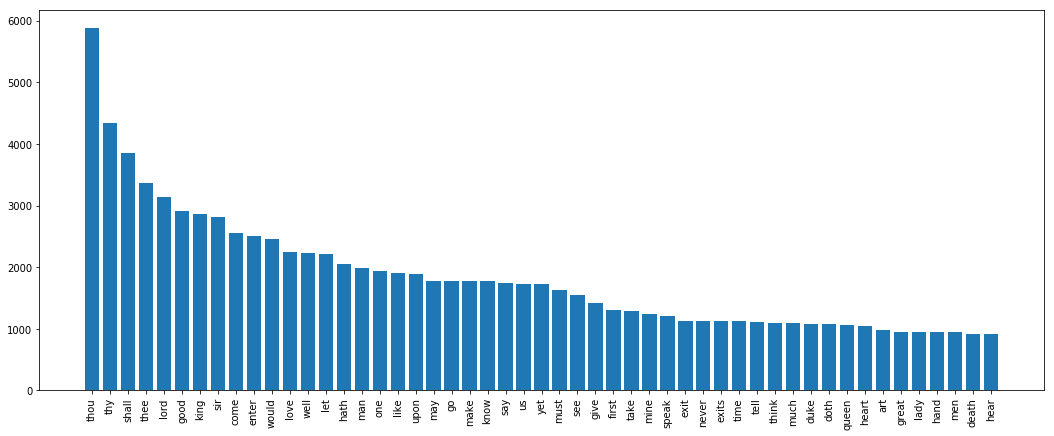

In [17]:
words_shake_50 = [w for w,f in topTuples_s[:51]]
freq_shake_50 = [f for w,f in topTuples_s[:51]]

plt.rcParams['figure.figsize'] = (18.0, 7.0)
plt.xticks(rotation='vertical')
plt.bar(words_shake_50, freq_shake_50)

### Reuters Corpus

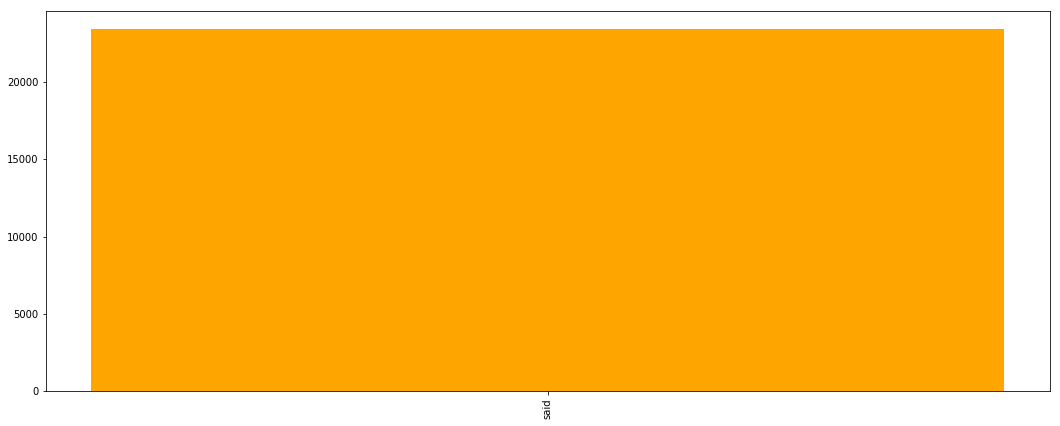

In [18]:
words_reuters_50 = [w for w,f in topTuples_r[:51]]
freq_reuters_50 = [f for w,f in topTuples_r[:51]]

plt.rcParams['figure.figsize'] = (18.0, 7.0)
plt.xticks(rotation='vertical')
bar_r = plt.bar(words_reuters_50, freq_reuters_50, color='orange')

## TSNE Corpus Visualization
### Visualize corpera relative to each other, including time-varied data

In [19]:
def process_words(raw_words: 'list of str'):
    '''Filters raw word list then returns single string version'''
    #convert to lowercase
    lower = [word.lower() for word in raw_words]
    
    #remove punctuation from tokens
    punc_filter = str.maketrans('', '', punctuation)
    stripped = [word.translate(punc_filter) for word in lower]
    
    #remove remaining alphanumerics
    words = [word for word in stripped if word.isalpha()]
    
    #filter out basic stopwords
    cleaned_word_bank = [word + ' ' for word in words if word not in stopset]
    return ''.join(cleaned_word_bank)


In [36]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets.base import Bunch
from yellowbrick.style import set_palette

shake_folder = './Shake_works'
textData_folder = './TextData'
all_shake_files = [file for t,y, file in os.walk(shake_folder)][0]
textData_dict = {}
for _,folder,_ in os.walk(textData_folder):
    for f in folder:
        textData_dict[f] = [file for t,y,file in os.walk(textData_folder+'/'+f)][0]
        
punctuation = string.punctuation.replace("'", "")
stopset = set(stopwords.words("english"))

# Load raw text data and labels simultaneously
data = []
labels = []

subset = np.random.choice(reuters.fileids(), 158)
# Reuters
for file in subset:
    raw_words = [str(word) for word in reuters.words(file)]
    processed = process_words(raw_words)
    data.append(processed)
    labels.append('Reuters')
    
# Shakespeare
for file in all_shake_files:
    raw_words = [str(word) for word in open(shake_folder+'/'+file).read().split()]
    processed = process_words(raw_words)
    data.append(processed)
    labels.append('Shakespeare')

# TextData
for time in textData_dict:
    for file in textData_dict[time]:
        raw_words = [str(word) for word in open(textData_folder+'/'+time+'/'+file, encoding='latin-1').read().split()]
        processed = process_words(raw_words)
        data.append(processed)
        labels.append(time)
corpus = Bunch(
    data=data,
    target=labels
)

1600s hist1.txt
1600s Old Mortality.txt
1600s The Black Tulip.txt
1600s The Bride of Lammermoor.txt
1700s poets.txt
1700s scottish_story.txt
1700s The Antiquary.txt
1700s The Maid of Maiden Lane.txt
1700s The Surgeon's Daughter.txt
1800s A Tale of Two Cities.txt
1800s Castle Richmond.txt
1800s Chamber's journal.txt
1800s london_medical_gazette.txt
1800s The Parisians, v10.txt
1900s 1900s1.txt
1900s tech1.txt
2000s BBC1.txt
2000s BBC2.txt


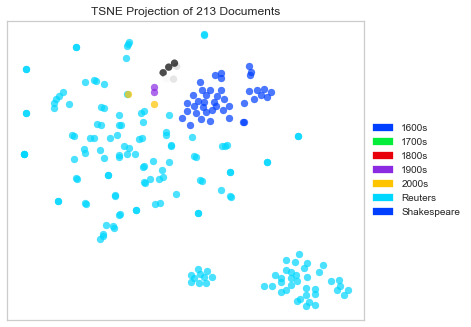

In [21]:
# Fit tf-idf vectorizer
TF_IDF = TfidfVectorizer()
docs = TF_IDF.fit_transform(corpus.data)

# Set color palette for plotting
set_palette('sns_dark')

# Construct visualizer and draw vectors
tsne = TSNEVisualizer()
tsne.fit(docs, corpus.target)
for label in tsne.ax.texts:
    label.set_size(100)
tsne.poof()



## Feature Exploration
### Apply truncated SVD to find words accounting for most variance in each corpus

In [22]:
from sklearn.decomposition import TruncatedSVD
print('---------------------\nTruncated SVD Reuters\n---------------------')

SVD = TruncatedSVD(n_components=15, n_iter=30)
SVD.fit_transform(reuters_data)

reut = []
shake = []
reut_var = []
shake_var = []

print('Top 10 Reuters words account for {}% of overall variance'.format(round(SVD.explained_variance_ratio_.sum()*100, 2)))
best_features = [vocab[i] for i in SVD.components_[0].argsort()[::-1]]

i = 0
for k, feature in enumerate(best_features):
    #if len(feature) >= 3:
    print(feature, round(SVD.explained_variance_ratio_[k-1]*100, 3))
    reut.append(feature)
    reut_var.append(round(SVD.explained_variance_ratio_[k-1]*100, 3))
    i += 1
    if i > 15:
        break
        
print('\n\n')
print('--------------------------\nTruncated SVD Shakespeare\n--------------------------')
SVD = TruncatedSVD(n_components=15, n_iter=30)
SVD.fit_transform(shakespeare_data)

print('Top 10 Shakespeare words account for {}% of overall variance'.format(round(SVD.explained_variance_ratio_.sum()*100, 2)))
best_features = [vocab[i] for i in SVD.components_[0].argsort()[::-1]]

i = 0
for k, feature in enumerate(best_features):
    print(feature, round(SVD.explained_variance_ratio_[k-1]*100, 3))
    shake.append(feature)
    shake_var.append(round(SVD.explained_variance_ratio_[k-1]*100, 3))
    i += 1
    if i > 15:
        break
        

---------------------
Truncated SVD Reuters
---------------------
Top 10 Reuters words account for 61.37% of overall variance
said
would
one
two
may
could
first
made
time
world
take



--------------------------
Truncated SVD Shakespeare
--------------------------
Top 10 Shakespeare words account for 96.02% of overall variance
death
two
cannot
thus
whose
true
fair
made
doth
mine
yet


In [ ]:
plt.rcParams['figure.figsize'] = (13.0, 5)
plt.xticks(rotation='vertical')
plt.title('Reuters Top Features', fontsize=30)
plt.ylabel('Percent Variance', fontsize=20)
plt.bar(reut, reut_var, color = 'green')

In [ ]:
plt.rcParams['figure.figsize'] = (13.0, 5)
plt.xticks(rotation='vertical')
plt.title('Shakespeare Top Features', fontsize=30)
plt.ylabel('Percent Variance', fontsize=20)
plt.bar(shake, shake_var, color = 'purple')

# Demonstration
### Use our training data to predict a number of documents from a range of centuries from 1600s - 2000s

The idea was to see if we could find a point in time to see when literature begins to be written in a modern style, compared to old english style

In [23]:
for clf, name in models:
    clf.fit(X,y)

In [24]:
from os import listdir
from os.path import isfile, join

def runCentury(century, clf, desc):
    print("Classification of documents from the " + century)
    onlyfiles = [f for f in listdir("TextData/"+century) if isfile(join("TextData/"+century, f))]
    for f in onlyfiles:
        doc = []
        with open(join("TextData/"+century,f), encoding='latin-1') as fi:
            word_list = [w.lower() for w in word_tokenize(fi.read())]
            doc = vectorize(word_list, vocab)
        clf.predict([doc])

In [25]:
centuries = ["1600s","1700s","1800s","1900s","2000s"]
for c in centuries:
    for clf, modelName in models:
        runCentury(c,clf,modelName)

Classification of documents from the 1600s
Classification of documents from the 1600s
Classification of documents from the 1600s
Classification of documents from the 1600s
Classification of documents from the 1600s
Classification of documents from the 1700s
Classification of documents from the 1700s
Classification of documents from the 1700s
Classification of documents from the 1700s
Classification of documents from the 1700s
Classification of documents from the 1800s
Classification of documents from the 1800s
Classification of documents from the 1800s
Classification of documents from the 1800s
Classification of documents from the 1800s
Classification of documents from the 1900s
Classification of documents from the 1900s
Classification of documents from the 1900s
Classification of documents from the 1900s
Classification of documents from the 1900s
Classification of documents from the 2000s
Classification of documents from the 2000s
Classification of documents from the 2000s
Classificat

## Confusion Matrices

In [ ]:
from yellowbrick.classifier import ConfusionMatrix
plt.subplots_adjust(hspace=0.4)
plt.rcParams['figure.figsize']=(18.0,12.0)  
fig, ax = plt.subplots(len(models), 5)
idx = 0
for clf, modelname in models:
    for i in range(len(training_sx)):
            plt.rcParams['figure.figsize']=(18.0,12.0)
            ax[idx,i].set_title(modelName)
            cm = ConfusionMatrix(ax=ax[idx,i], model=clf, classes=[0,1])
            training_global_x = (np.concatenate((training_sx[i], training_rx[i]), axis=0))
            training_global_y = (np.concatenate((training_sy[i], training_ry[i]), axis=0))
            validation_global_x = (np.concatenate((validation_sx[i], validation_rx[i]), axis=0))
            validation_global_y = (np.concatenate((validation_sy[i], validation_ry[i]), axis=0))

            cm.fit(training_global_x,training_global_y)
            cm.score(validation_global_x, validation_global_y)
    idx+=1
            


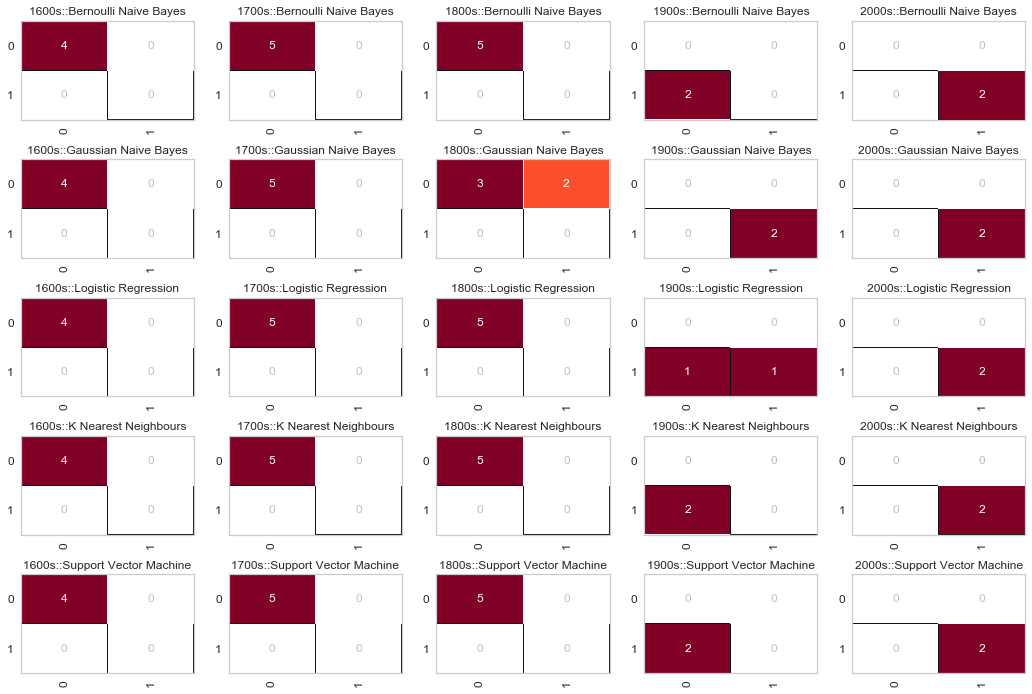

In [28]:
from yellowbrick.classifier import ConfusionMatrix

fig, AX = plt.subplots(len(models), 5)   
plt.subplots_adjust(hspace=0.4)
plt.rcParams['figure.figsize']=(18.0,12.0)  
modelNum=0
for model, modelName in models:
    centuries = ["1600s","1700s","1800s","1900s","2000s"]
    for i,c in enumerate(centuries):
        onlyfiles = [f for f in listdir("TextData/"+c) if isfile(join("TextData/"+c, f))]
        test_set = []
        AX[modelNum, i].set_title(c + "::" + modelName)
        cm = ConfusionMatrix(ax=AX[modelNum, i], model=model, classes=[0,1])
        cm.fit(X,y)            
        for f in onlyfiles:
            with open(join("TextData/"+c,f), "r", encoding="latin-1") as fi:
                    word_list = [w.lower() for w in word_tokenize(fi.read())]
                    doc = vectorize(word_list, vocab)
                    test_set.append(doc)                    
        test_set = np.array(test_set)   
        test_answer = np.zeros(test_set.shape[0]) 
        if(c == "1900s" or c == "2000s"):
            test_answer = np.ones(test_set.shape[0])
        cm.score(test_set, test_answer)
    modelNum+=1


   

# Result interpretation

Two main insights can be drawn from the above confusion matrix:

- The models seem to have performed fairly similarly across the board, with the exception of Gaussian Naive Bayes, which makes sense, since at no point did we assume that our documents follow a gaussian distribution
- We can conclude that roughly around the 1900s, people began to write in a style closer to Reuters rather than Shakespere